# Import libraries

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import random

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# Environment

In [ ]:
# env = gym.make("FrozenLake-v1")
# # P(s'|S=s, A=a)
# # Ex: P(s'|S=0, A=3)
# env.P[0][3] # Transition model
# env.observation_space.n -> 16
# env.action_space.n -> 4

In [4]:
env = gym.make("FrozenLake-v1")
env.observation_space.sample()[None]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


TypeError: ignored

In [5]:
a = np.array([[
    [1,2,3],
    [1,2,3],
    [1,2,3],
]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
a[]

In [6]:
a.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1, 3, 3)

In [ ]:
def play(env, policy, render=False):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False

    env.reset()
    while not done:
        action = policy[state]
        next_state, reward, done, info = env.step(action)
        if render:
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            plt.title(f'Step: {str(steps)}')
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            time.sleep(1)
            if done:
                break

        total_reward += reward
        steps += 1
        state = next_state
        
    ipythondisplay.clear_output(wait=True)
    env.close()

    return (total_reward, steps)

In [ ]:
def play_multiple_times(env, policy, max_episodes):
    success = 0
    list_of_steps = []
    for i in range(max_episodes):
        total_reward, steps = play(env, policy)

        if total_reward > 0:
            success += 1
            list_of_steps.append(steps)

    print(f'Number of successes: {success}/{max_episodes}')
    print(f'Average number of steps: {np.mean(list_of_steps)}')

# Policy evaluation

In [ ]:
def policy_evaluation(env, policy, max_iters=500, gamma=0.9):
    # Initialize the values of all states to be 0
    v_values = np.zeros(env.observation_space.n)

    for i in range(max_iters):
        prev_v_values = np.copy(v_values)

        # Update the value of each state
        for state in range(env.observation_space.n):
            action = policy[state]

            # Compute the q-value of the action
            q_value = 0
            for prob, next_state, reward, done in env.P[state][action]:
                q_value += prob * (reward + gamma * prev_v_values[next_state])

            v_values[state] = q_value # update v-value
        
        # Check convergence
        if np.all(np.isclose(v_values, prev_v_values)):
            print(f'Converged at {i}-th iteration.')
            break
    
    return v_values

# Value iteration

In [ ]:
def value_iteration(env, max_iters=500, gamma=0.9):
    # initialize
    v_values = np.zeros(env.observation_space.n)

    for i in range(max_iters):
        prev_v_values = np.copy(v_values)

        # update the v-value for each state
        for state in range(env.observation_space.n):
            q_values = []
            
            # compute the q-value for each action that we can perform at the state
            for action in range(env.action_space.n):
                q_value = 0
                # loop through each possible outcome
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * prev_v_values[next_state])
                
                q_values.append(q_value)
            
            # select the max q-values
            best_action = np.argmax(q_values)
            v_values[state] = q_values[best_action]
        
        # check convergence
        if np.all(np.isclose(v_values, prev_v_values)):
            # print(f'Converged at {i}-th iteration.')
            break
    
    return v_values

In [ ]:
def policy_extraction(env, v_values, gamma=0.9):
    # initialize
    policy = np.zeros(env.observation_space.n)

    # loop through each state in the environment
    for state in range(env.observation_space.n):
        q_values = []
        # loop through each action
        for action in range(env.action_space.n):
            q_value = 0
            # loop each possible outcome
            for prob, next_state, reward, done in env.P[state][action]:
                q_value += prob * (reward + gamma * v_values[next_state])
            
            q_values.append(q_value)
        
        # select the best action
        best_action = np.argmax(q_values)
        policy[state] = best_action
    
    return policy

# Policy iteration

In [ ]:
def policy_iteration(env, max_iters=500, gamma=0.9):
    # Random policy
    init_policy = np.array([env.action_space.sample() for i in range(env.observation_space.n)])

    for i in range(max_iters):
        # POLICY EVALUATION
        
        # Initialize the values of all states to be 0
        v_values = np.zeros(env.observation_space.n)

        for j in range(max_iters):
            prev_v_values = np.copy(v_values)

            # Update the value of each state
            for state, action in enumerate(init_policy):

                # Compute the q-value of the action
                q_value = 0

                # Loop through each possible outcome
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * prev_v_values[next_state])

                # update v-value
                v_values[state] = q_value 
            
            # Check convergence
            if np.all(np.isclose(v_values, prev_v_values)):
                break


        # POLICY IMPROVEMENT
        prev_policy = np.copy(init_policy)

        # Calculate value of state
        for state in range(env.observation_space.n):
            q_values = []

            # Calculate q_value for each action
            for action in range(env.action_space.n):
                q_value = 0

                # Loop through each possible outcome
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * v_values[next_state])

                q_values.append(q_value)
            
            # Get the best action 
            best_action = np.argmax(q_values)
            init_policy[state] = best_action
            
        # Check convergence
        if np.all(np.isclose(init_policy, prev_policy)):
            # print(f'Converged at {i}-th iteration.')
            break
    
    return init_policy

# Result

In [ ]:
MAX_ITERS = 500
GAMMA = 0.9
MAX_EPISODES = 1000

## FrozenLake-v1

In [ ]:
env = gym.make('FrozenLake-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Value iteration

In [ ]:
%%timeit
# [55, 48.9, 47.7, 52.5, 50.3, 48.8, 45.5, 50, 48.4, 49.8] ms
v_values = value_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)
policy = policy_extraction(env, v_values, GAMMA)

2.48 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

Number of successes: 705/1000
Average number of steps: 36.797163120567376


### Policy iteration

In [ ]:
%%timeit
# [43.8, 40.5, 39.2, 35.1, 35, 37, 35.7, 34.5, 39.4, 38.3] ms
policy = policy_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)

4.26 s ± 445 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

Number of successes: 732/1000
Average number of steps: 38.10792349726776


(0.0, 23)

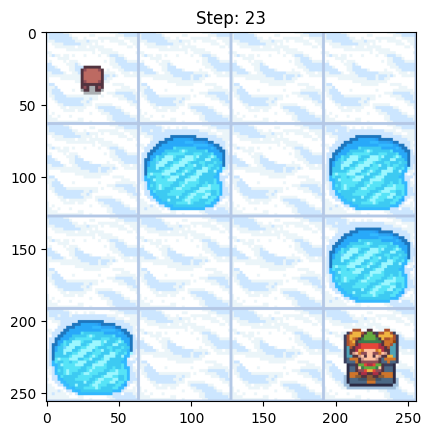

In [ ]:
# Playing with policy from POLICY ITERATION
play(env, policy, True)

## FrozenLake8x8-v1

In [ ]:
env = gym.make('FrozenLake8x8-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Value iteration

In [ ]:
%%timeit
# [236, 251, 262, 274, 243, 261, 269, 232, 291, 326] ms
v_values = value_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)
policy = policy_extraction(env, v_values, GAMMA)

312 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

### Policy iteration

In [ ]:
%%timeit
# [230, 212, 199, 233, 197, 222, 207, 218, 184, 235] ms
policy = policy_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)

184 ms ± 71.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

(0.0, 55)

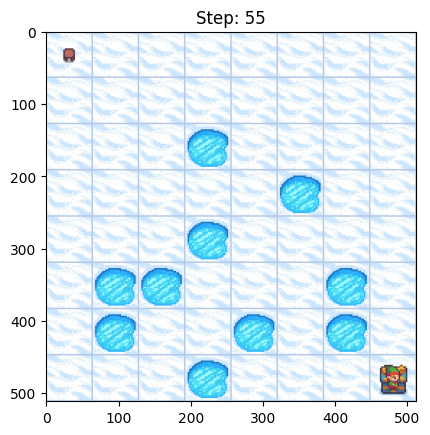

In [ ]:
# Playing with policy from POLICY ITERATION
play(env, policy, True)

## Taxi-v3

In [ ]:
env = gym.make('Taxi-v3')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Value iteration

In [ ]:
%%timeit
# [2.32, 2.41, 2.49, 2.53, 2.39, 2.38, 2.3, 2.45, 2.35, 2.41] s
v_values = value_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)
policy = policy_extraction(env, v_values, GAMMA)

2.59 s ± 430 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

Number of successes: 966/1000
Average number of steps: 14.0175983436853


### Policy iteration

In [ ]:
%%timeit
# [4.3, 4.32, 4.11, 4.25, 4.25, 4.33, 4.14, 4.2, 4.44, 4.15] s
policy = policy_iteration(env, max_iters=MAX_ITERS, gamma=GAMMA)

4.6 s ± 822 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
play_multiple_times(env, policy=policy, max_episodes=MAX_EPISODES)

Number of successes: 969/1000
Average number of steps: 13.95562435500516


(-13, 13)

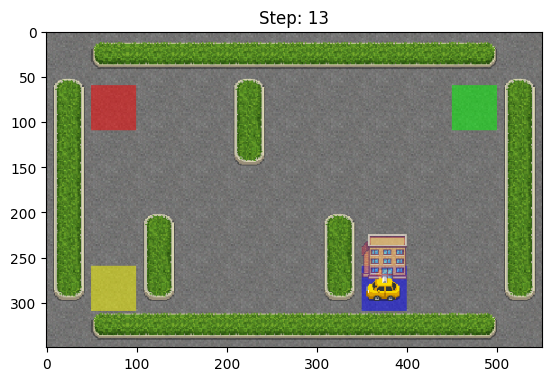

In [ ]:
# Playing with policy from POLICY ITERATION
play(env, policy, True)

## Evaluation

*   FrozenLake

$
\begin{array}{||c|c|c|} \hline
  & Convergence & Average\hspace{1mm}runtime (ms) \\ \hline
Value\hspace{1mm}Iteration & 79 &  49.69 \\
Policy\hspace{1mm}Iteration & 5 & 37.85 \\ \hline
\end{array}
$

</br>
</br>

*   FrozenLake8x8

$
\begin{array}{||c|c|c|} \hline
  & Convergence & Average\hspace{1mm}runtime (ms) \\ \hline
Value\hspace{1mm}Iteration & 118 &  264.5 \\
Policy\hspace{1mm}Iteration & 8 & 213.7 \\ \hline
\end{array}
$

</br>
</br>

*   Taxi

$
\begin{array}{||c|c|c|} \hline
  & Convergence & Average\hspace{1mm}runtime (s) \\ \hline
Value\hspace{1mm}Iteration & 116 &  2.403 \\
Policy\hspace{1mm}Iteration & 17 &  4.249 \\ \hline
\end{array}
$


From the above results, we can draw some conclusions about **value iteration (VI**) and **policy iteration (PI)**

*   PI converges much faster in comparison to VI
*   Game with a small number of states
    * PI is faster than VI
*   Game with a big number of states
    * PI is slower than VI

PI can converge much faster than VI but in practice we can say that VI is faster.


